# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import plotly.express as px
from termcolor import colored
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
tqdm.pandas()
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
variables = util.variables

In [2]:
# Ntuple locations
files = ['MC14ri_sigDDst_foldex_e_7/hashed_sigDDst.root:B0', 
         'MC14ri_normDDst_foldex_e_7/hashed_normDDst.root:B0',
         'MC14ri_Dststell2_foldex_e_8/hashed_Dststell2.root:B0', 
         'MC14ri_DststTau1_foldex_e_7/hashed_DststTau1.root:B0',
         'MC14ri_DststTau2_foldex_e_7/hashed_DststTau2.root:B0']

lepton_mode = 'e'
columns=['__experiment__','__run__','__event__','__production__','B0_isContinuumEvent',
         'DecayMode', 'p_D_l', 'B_D_ReChi2','B0_mcPDG','B0_mcErrors','D_mcErrors','D_mcPDG',
         f'{lepton_mode}_genMotherPDG', f'{lepton_mode}_mcPDG',
         f'{lepton_mode}_mcErrors',f'{lepton_mode}_pSig']+variables

In [3]:
df_test = uproot.concatenate([f'../Samples/Signal_MC14ri/{f}' for f in files],
                        library="np",
                        #cut='DecayMode>0',
                        filter_branch=lambda branch: branch.name in columns)
df = pd.DataFrame(df_test)

In [12]:
df_test = uproot.concatenate([f'../Samples/Signal_MC14ri/{f}' for f in files],
                        library="np",
                        cut='DecayMode==0',
                        filter_branch=lambda branch: branch.name in columns)
df = pd.DataFrame(df_test)

In [6]:
# Ntuple locations
files = [ 
         #'MC14ri_normDDst_foldex_e_7/hashed_normDDst.root:B0',
         'MC14ri_Dststell2_foldex_e_8/hashed_Dststell2.root:B0', 
         ]

lepton_mode = 'e'
columns=['__experiment__','__run__','__event__','__production__','B0_isContinuumEvent',
         'DecayMode', 'p_D_l', 'B_D_ReChi2','B0_mcPDG','B0_mcErrors','D_mcErrors','D_mcPDG',
         f'{lepton_mode}_genMotherPDG', f'{lepton_mode}_mcPDG',
         f'{lepton_mode}_mcErrors',f'{lepton_mode}_pSig']+variables

df_test = uproot.concatenate([f'../Samples/Signal_MC14ri/{f}' for f in files],
                        library="np",
                        #cut='DecayMode>0',
                        filter_branch=lambda branch: branch.name in columns)
df = pd.DataFrame(df_test)

In [11]:
total = []
for file_name in tqdm(files, desc=colored('Loading parquets', 'blue')):
    filename=f'../Samples/Signal_MC14ri/{file_name}'

    with uproot.open(filename) as file:
        df = pd.DataFrame(file.arrays(entry_start=0,entry_stop=None,library="np",
                                      cut='DecayMode>0', # exclude bkg
                                      filter_branch=lambda branch: branch.name in columns))

    total.append(df)
    del df
df_signals = pd.concat(total,ignore_index=True).reset_index(drop=True)

df = df_signals

# file_path='../Samples/Generic_MC14ri/MC14ri_qqbar_e_bengal_3/qqbar_0.parquet'

# # get the total number of rows in the file
# total_rows = pd.read_parquet(file_path, engine="pyarrow", columns=['__experiment__']).shape[0]

# # set the stop parameter to read the first 36% of the data
# stop = int(0.364 * total_rows)

# # load the data using pd.read_parquet
# df_continuum = pd.read_parquet(file_path, engine="pyarrow",
#                               columns=['__experiment__','__run__','__event__','__production__',
#                                         'B0_isContinuumEvent', 'p_D_l', 'B_D_ReChi2',
#                                         'B0_mcPDG','B0_mcErrors','D_mcErrors','D_mcPDG',
#                                         f'e_genMotherPDG', f'e_mcPDG',
#                                         f'e_mcErrors']+variables)
# df_continuum = df_continuum.sample(n=stop, random_state=0)
# df_continuum['DecayMode'] = 10
# df_continuum['e_CMS_mcP']=0
# df_continuum['e_pErr']=0
# df_continuum['e_pSig']=0
# df = pd.concat([df_B, df_continuum] ,ignore_index=True).reset_index(drop=True)

Loading parquets:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

cut='signal_prob==largest_prob and signal_prob>0.8'

In [5]:
# apply but skip the MVA cut
df_cut=df_lgb#.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'e', template=False)
mpl=util.mpl(samples)
ply=util.ply(df)
for name, df in samples.items():
    print(name, len(df))

$D\tau\nu$ 37307
$D^\ast\tau\nu$ 42678
$D^{\ast\ast}\tau\nu$_mixed 45523
$D^{\ast\ast}\tau\nu$_charged 75392
$D\ell\nu$ 71007
$D^\ast\ell\nu$ 105854
res_$D^{\ast\ast}\ell\nu$_mixed 30753
nonres_$D^{\ast\ast}\ell\nu$_mixed 6602
gap_$D^{\ast\ast}\ell\nu$_mixed 12796
res_$D^{\ast\ast}\ell\nu$_charged 33337
nonres_$D^{\ast\ast}\ell\nu$_charged 6275
bkg_fakeTC 59950
bkg_fakeD 2216907
bkg_Odecay 127790
bkg_combinatorial 219435
bkg_misID 12580
bkg_continuum 0
bkg_others 1507


In [23]:
df_test1 = samples['bkg_others']
df_test1[['B0_mcErrors','B0_mcPDG','D_mcErrors','D_mcPDG','e_genMotherPDG','e_mcErrors','e_mcPDG','DecayMode']]

,B0_mcErrors,B0_mcPDG,D_mcErrors,D_mcPDG,e_genMotherPDG,e_mcErrors,e_mcPDG,DecayMode
105175,384.0,-425.0,0.0,-411.0,-425.0,384.0,211.0,0
105194,312.0,521.0,0.0,-411.0,521.0,0.0,-11.0,10
105213,1320.0,-521.0,0.0,411.0,-521.0,0.0,11.0,10
105231,1336.0,-521.0,0.0,411.0,-521.0,0.0,11.0,10
105235,296.0,-521.0,0.0,411.0,-521.0,0.0,11.0,10
...,...,...,...,...,...,...,...,...
151971,312.0,521.0,0.0,-411.0,521.0,0.0,-11.0,10
151982,312.0,521.0,0.0,-411.0,521.0,0.0,-11.0,10
49014,2360.0,521.0,0.0,-411.0,521.0,2048.0,-11.0,10
49019,312.0,521.0,0.0,-411.0,521.0,0.0,-11.0,10


In [6]:
# apply the mva cut
df_cut=df_lgb.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'e', template=False)
mpl=util.mpl(samples)
ply=util.ply(df)
for name, df in samples.items():
    print(name, len(df))

$D\tau\nu$ 19803
$D^\ast\tau\nu$ 16342
$D^{\ast\ast}\tau\nu$_mixed 11018
$D^{\ast\ast}\tau\nu$_charged 18066
$D\ell\nu$ 21719
$D^\ast\ell\nu$ 27601
res_$D^{\ast\ast}\ell\nu$_mixed 7553
nonres_$D^{\ast\ast}\ell\nu$_mixed 1090
gap_$D^{\ast\ast}\ell\nu$_mixed 2145
res_$D^{\ast\ast}\ell\nu$_charged 8042
nonres_$D^{\ast\ast}\ell\nu$_charged 1014
bkg_fakeTC 2816
bkg_fakeD 73829
bkg_Odecay 38569
bkg_combinatorial 21218
bkg_misID 1666
bkg_continuum 0
bkg_others 203


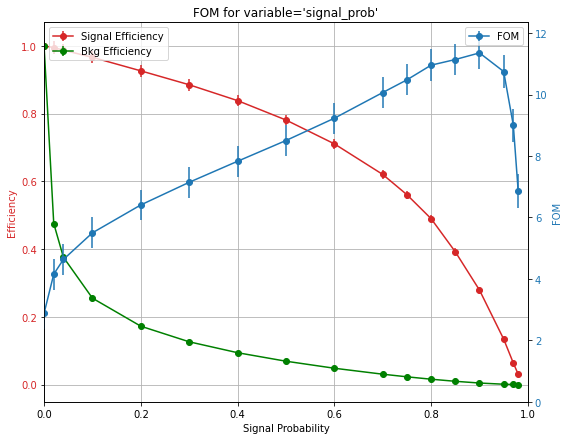

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

In [25]:
test_p = [0,0.02,0.04,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.97,0.98]
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'], bkgModes=['bkg_fakeDTC','bkg_fakeB','bkg_continuum'], variable='signal_prob', test_points=test_p, cut=None)

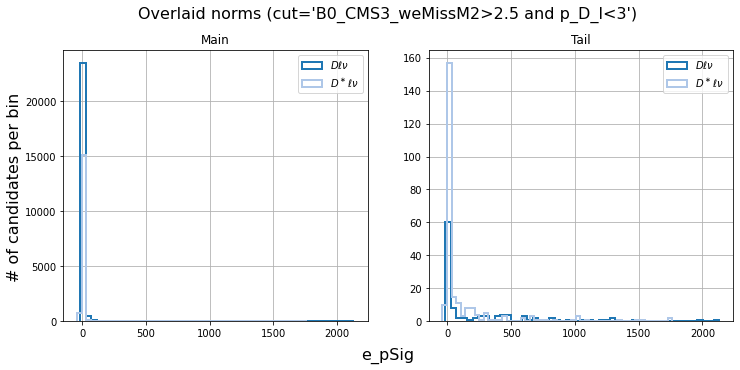

In [10]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3')

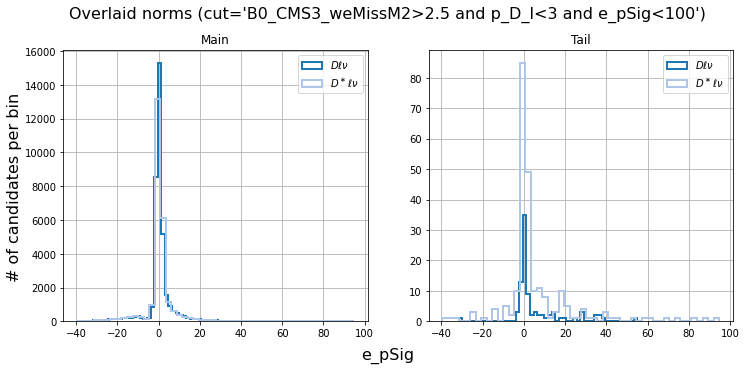

In [9]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3 and e_pSig<100')

In [23]:
for name, df in samples.items():
    print(name, len(df.query('nElectrons90+nMuons90==1'))/(len(df)+1))

$D\tau\nu$ 0.5691056910569106
$D^\ast\tau\nu$ 0.5693069306930693
$D\ell\nu$ 0.8000362910542551
$D^\ast\ell\nu$ 0.7994846568282971
$D^{\ast\ast}\tau\nu$ 0.48214285714285715
$D^{\ast\ast}\ell\nu$ 0.7722292699803944
bkg_fakeDTC 0.6518145885734818
bkg_fakeB 0.6394163150492265
bkg_continuum 0.0
bkg_others 0.6993464052287581


In [24]:
for name, df in samples.items():
    print(name, len(df.query('nElectrons90+nMuons90==1 and ROEeidBDT<0.5 and ROEmuidBDT<0.5'))/(len(df)+1))

$D\tau\nu$ 0.5447154471544715
$D^\ast\tau\nu$ 0.5643564356435643
$D\ell\nu$ 0.7680223967649117
$D^\ast\ell\nu$ 0.7672366674474896
$D^{\ast\ast}\tau\nu$ 0.48214285714285715
$D^{\ast\ast}\ell\nu$ 0.7481259370314842
bkg_fakeDTC 0.7509881422924901
bkg_fakeB 0.6218354430379747
bkg_continuum 0.0
bkg_others 0.6764705882352942


# 2. Plot

array([<AxesSubplot:title={'center':'0.0'}>,
       <AxesSubplot:title={'center':'1.0'}>], dtype=object)

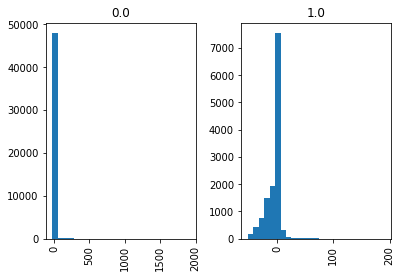

In [8]:
samples[r'$D\ell\nu$'].eval('e_pSig = (e_mcP - e_p)/e_pErr', inplace=True)
samples[r'$D\ell\nu$'].hist('e_pSig',bins=25, by='e_isBremsCorrected')

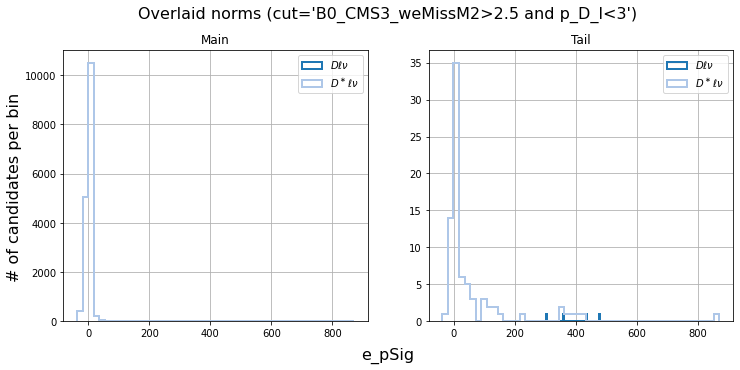

In [15]:
mpl.plot_norms_overlaid(variable='e_pSig',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3')

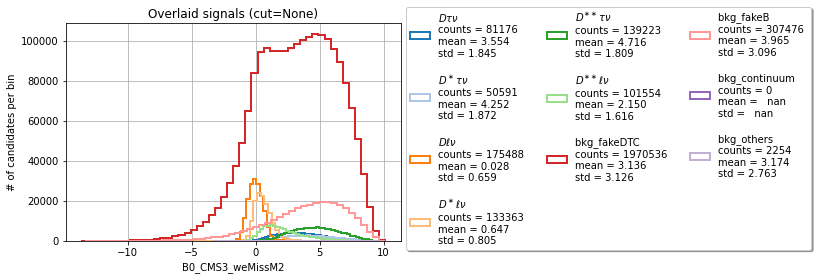

In [6]:
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2')

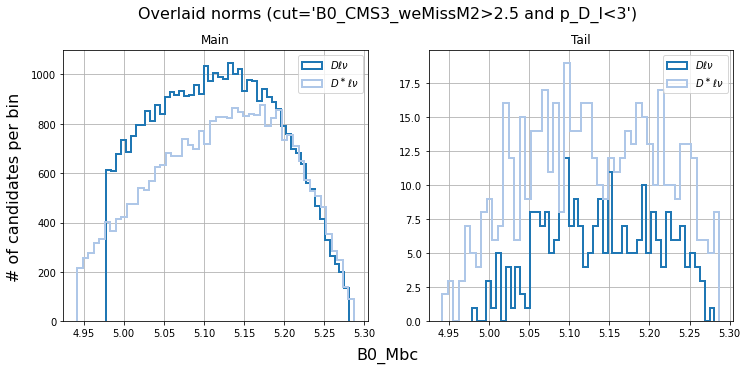

In [23]:
mpl.plot_norms_overlaid(variable='B0_Mbc',cut='B0_CMS3_weMissM2>2.5 and p_D_l<3')

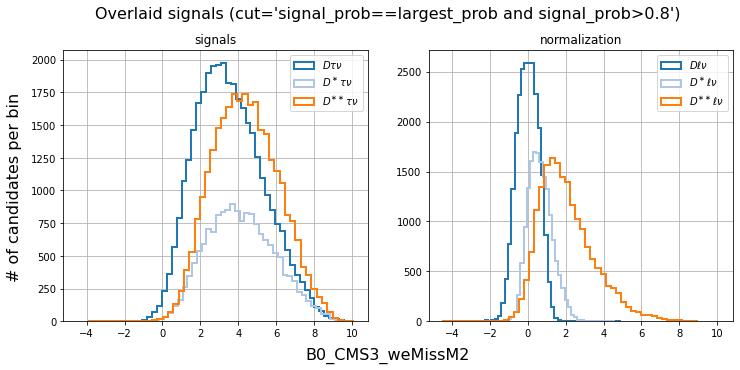

In [12]:
mpl.plot_signals_overlaid(variable='B0_CMS3_weMissM2',cut='signal_prob==largest_prob and signal_prob>0.8')

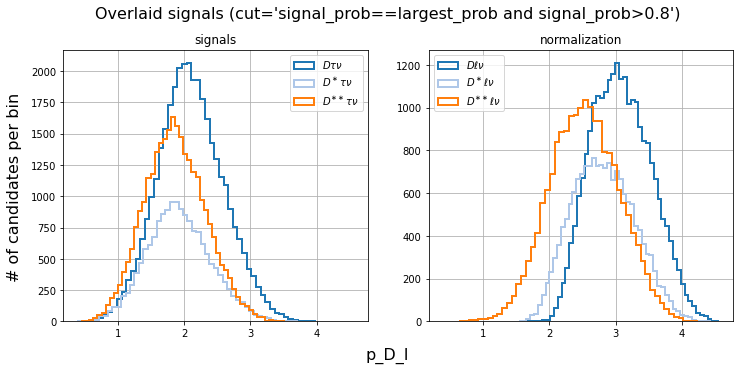

In [11]:
mpl.plot_signals_overlaid(variable='p_D_l',cut='signal_prob==largest_prob and signal_prob>0.8')

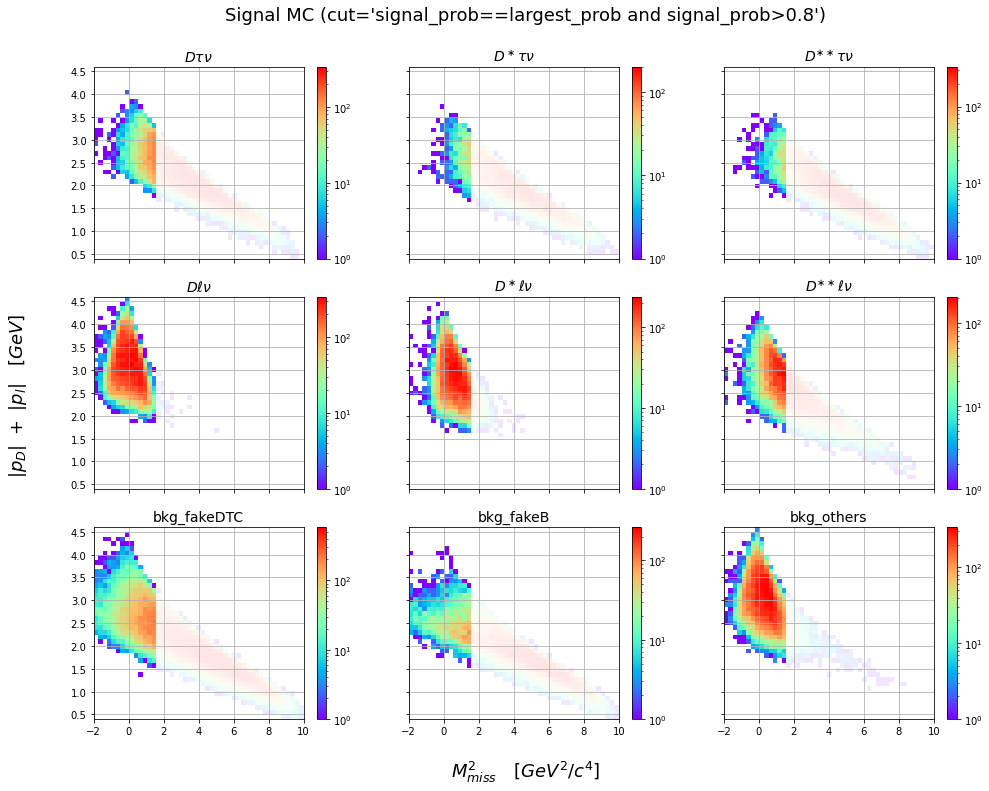

In [10]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', mask=[1.6,1,0.1])

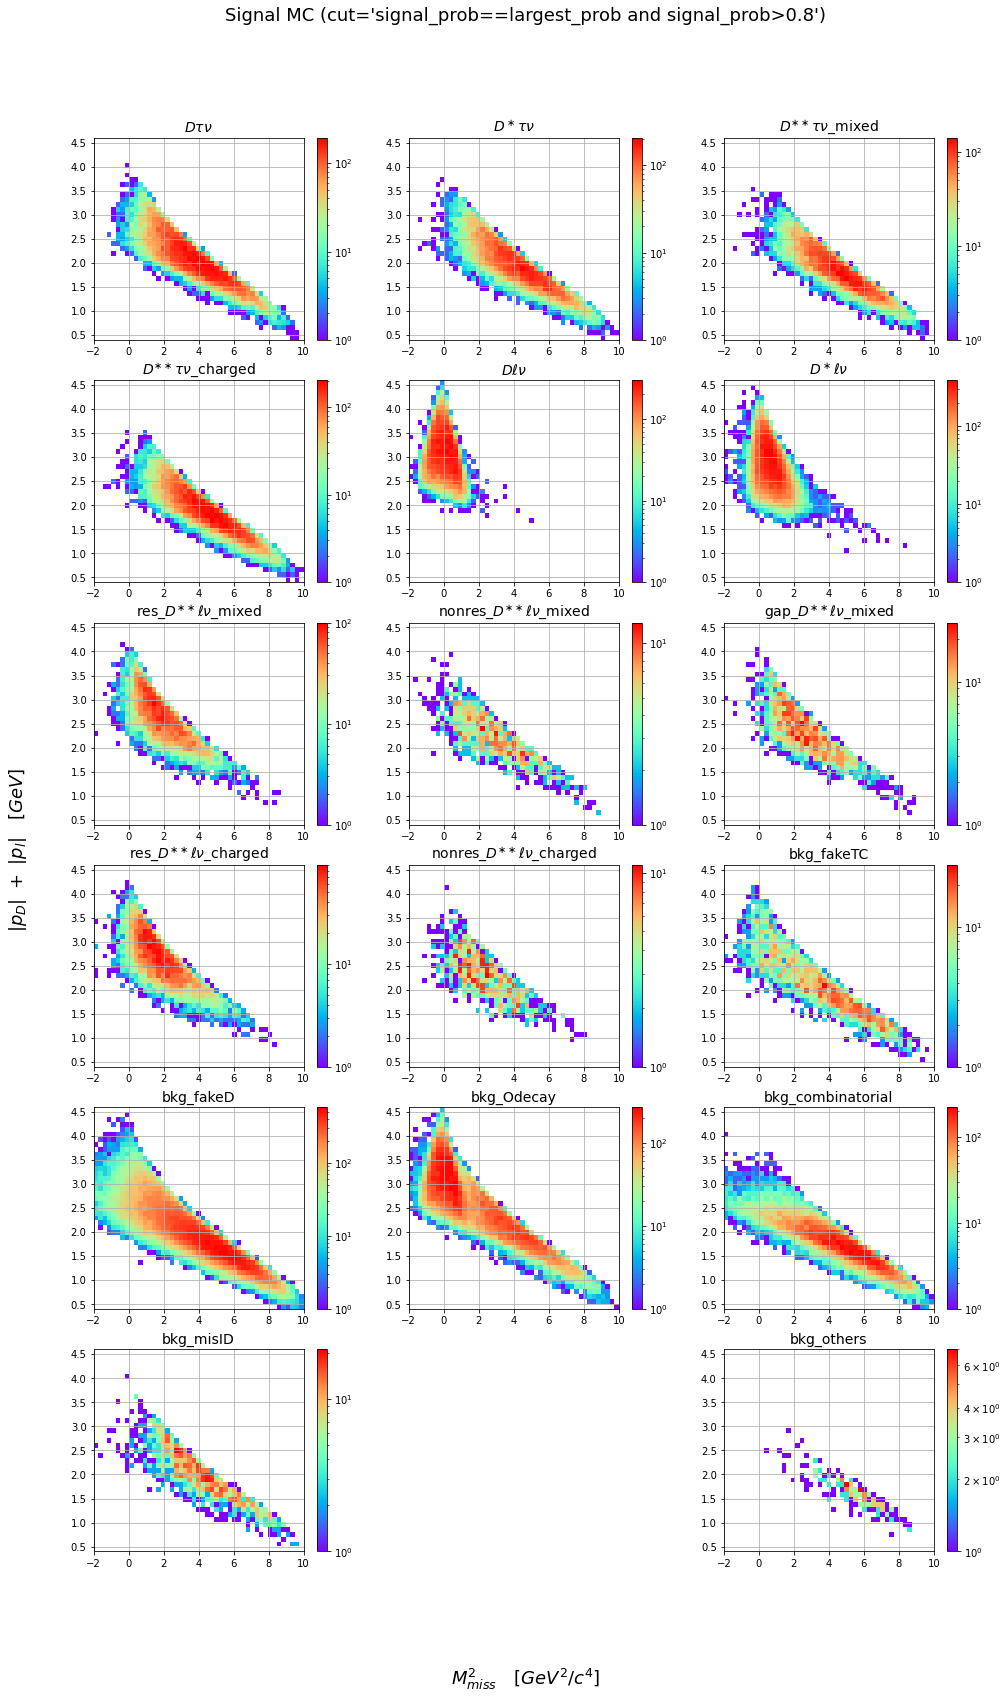

In [10]:
mpl.plot_hist_2d(cut='signal_prob==largest_prob and signal_prob>0.8', mask=None)

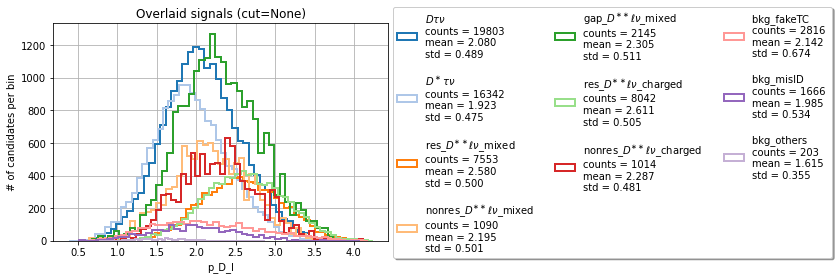

In [21]:
mpl.plot_all_overlaid(variable='p_D_l',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

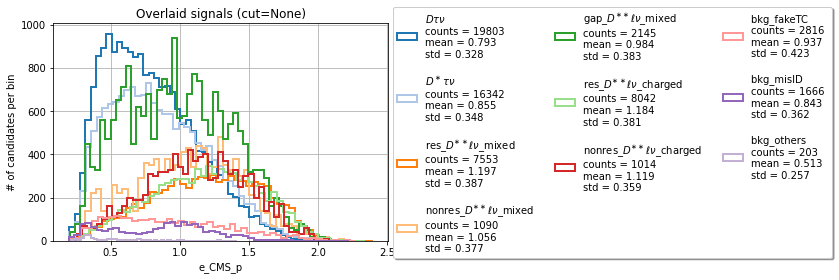

In [24]:
mpl.plot_all_overlaid(variable='e_CMS_p',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

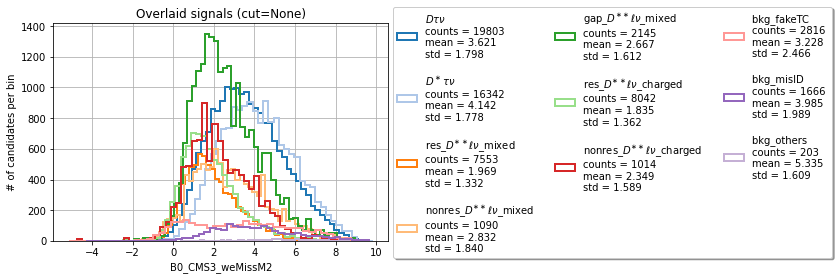

In [22]:
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2',cut=None,
                      mask=['bkg_fakeD','bkg_Odecay','bkg_combinatorial',
                             r'$D\ell\nu$',r'$D^\ast\ell\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',])

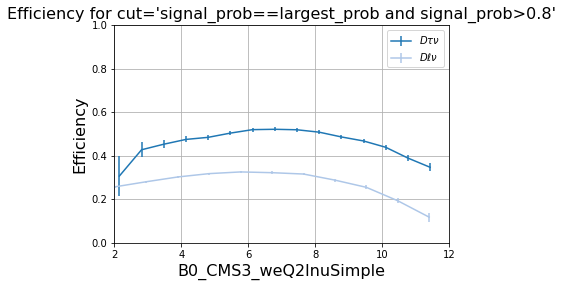

In [11]:
mpl.plot_cut_efficiency(cut='signal_prob==largest_prob and signal_prob>0.8', variable='B0_CMS3_weQ2lnuSimple')

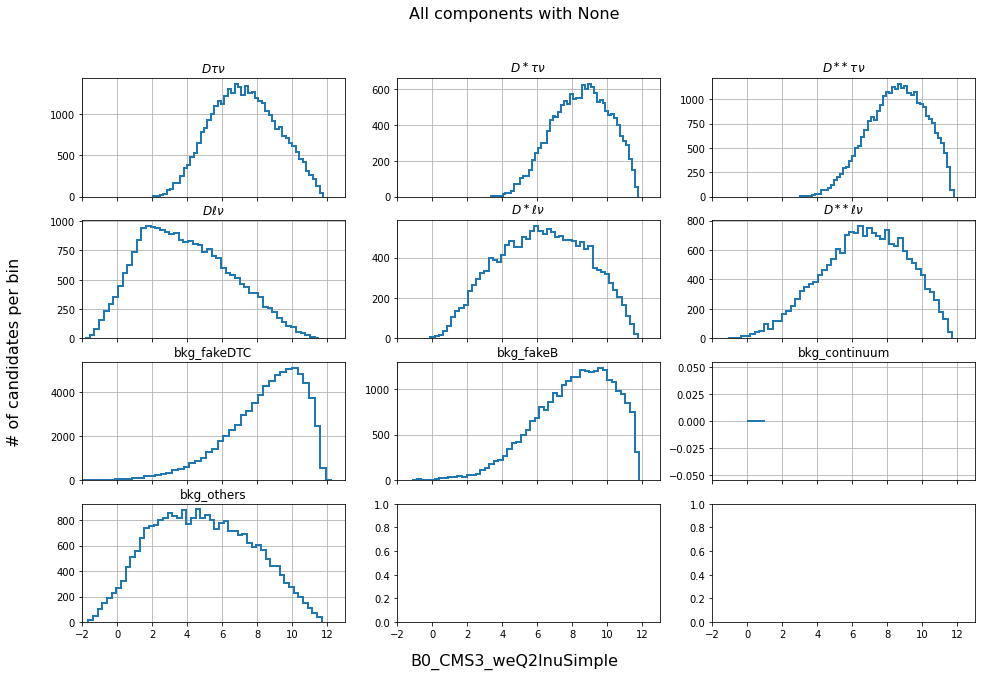

In [5]:
mpl.plot_all_separately(variable='B0_CMS3_weQ2lnuSimple',xlim=[-2,13])